In [15]:
from manifold_learning import IMD
from FastCCM import CCM
import numpy as np
from pydmd import DMD, BOPDMD, HAVOK
from manifold_learning.utils import utils
from sklearn.decomposition import PCA
from pydmd.preprocessing import zero_mean_preprocessing
from pydmd.plotter import plot_summary
from manifold_learning.data.data_loader import load_csv_dataset,get_truncated_lorenz_rand
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import imageio
import os
import tempfile
import importlib
import umap
importlib.reload(CCM)
importlib.reload(utils)

2024-07-22 15:10:01.118067: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-22 15:10:01.279492: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-22 15:10:01.897069: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


<module 'manifold_learning.utils.utils' from '/home/iaroslav/Documents/Python projects/manifold_learning/src/manifold_learning/utils/utils.py'>

In [2]:
X = get_truncated_lorenz_rand(400,n_steps=20000)

In [3]:
def gaussian_kernel(x, y, sigma=1.0):
    return np.exp(-np.linalg.norm(x - y,axis=1)**2 / (2 * sigma**2))

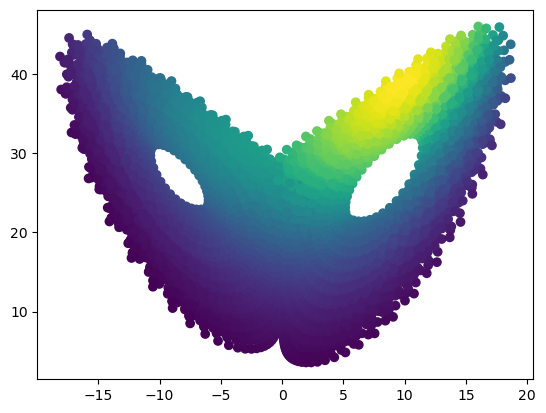

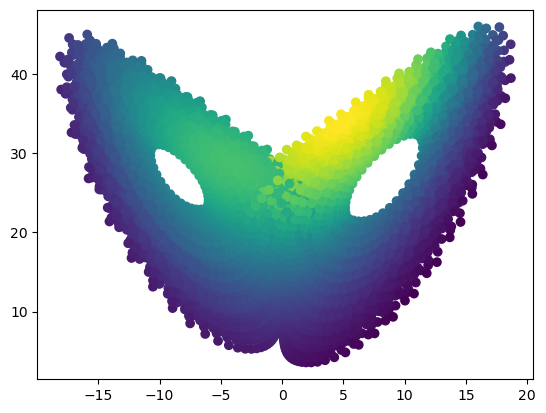

In [4]:
plt.scatter(X[:,0],X[:,2],c=gaussian_kernel(X,X[1100],sigma=15))
plt.show()
plt.scatter(X[:,0],X[:,2],c=gaussian_kernel(X,X[1800],sigma=15))
plt.show()

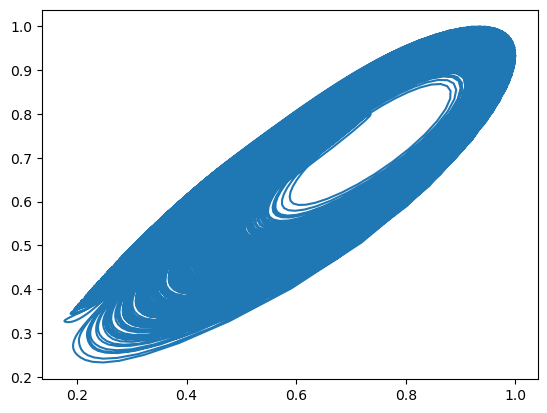

In [5]:
plt.plot(gaussian_kernel(X,X[1100],sigma=20),gaussian_kernel(X,X[1800],sigma=20))

In [34]:
exp_kernel_grid = np.array(np.meshgrid(np.linspace(X[:,0].min(),X[:,0].max(),40), np.linspace(X[:,2].min(),X[:,2].max(),40))).reshape(2,-1).T
observables = np.array([gaussian_kernel(X[:,[0,2]],e,sigma=5) for e in exp_kernel_grid]).T
with tempfile.TemporaryDirectory() as tempdir:
    filenames = []
    for i, frame in enumerate(observables.reshape(-1,40,40)[:2000]):
        plt.imshow(frame, cmap='viridis')
        plt.axis('off')
        filename = os.path.join(tempdir, f'frame_{i}.png')
        plt.savefig(filename)
        filenames.append(filename)
        plt.close()

    with imageio.get_writer('output.mp4', fps=30) as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)

/tmp/ipykernel_474863/4228224139.py:13: DeprecationWarning:

Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.



In [7]:
exp_kernel_grid = np.array(np.meshgrid(np.linspace(X[:,0].min(),X[:,0].max(),8), np.linspace(X[:,2].min(),X[:,2].max(),8))).reshape(2,-1).T

In [12]:
X_ = [get_truncated_lorenz_rand(800,n_steps=40000)[:,[0,2]] for i in range(1)]
observables = np.concatenate([np.array([gaussian_kernel(x,e,sigma=15) for e in exp_kernel_grid]) for x in X_]).T


In [9]:
observables = StandardScaler().fit_transform(observables)

In [ ]:
observables = utils.get_td_embedding_np(observables,3,5).reshape(-1,3*observables.shape[1])


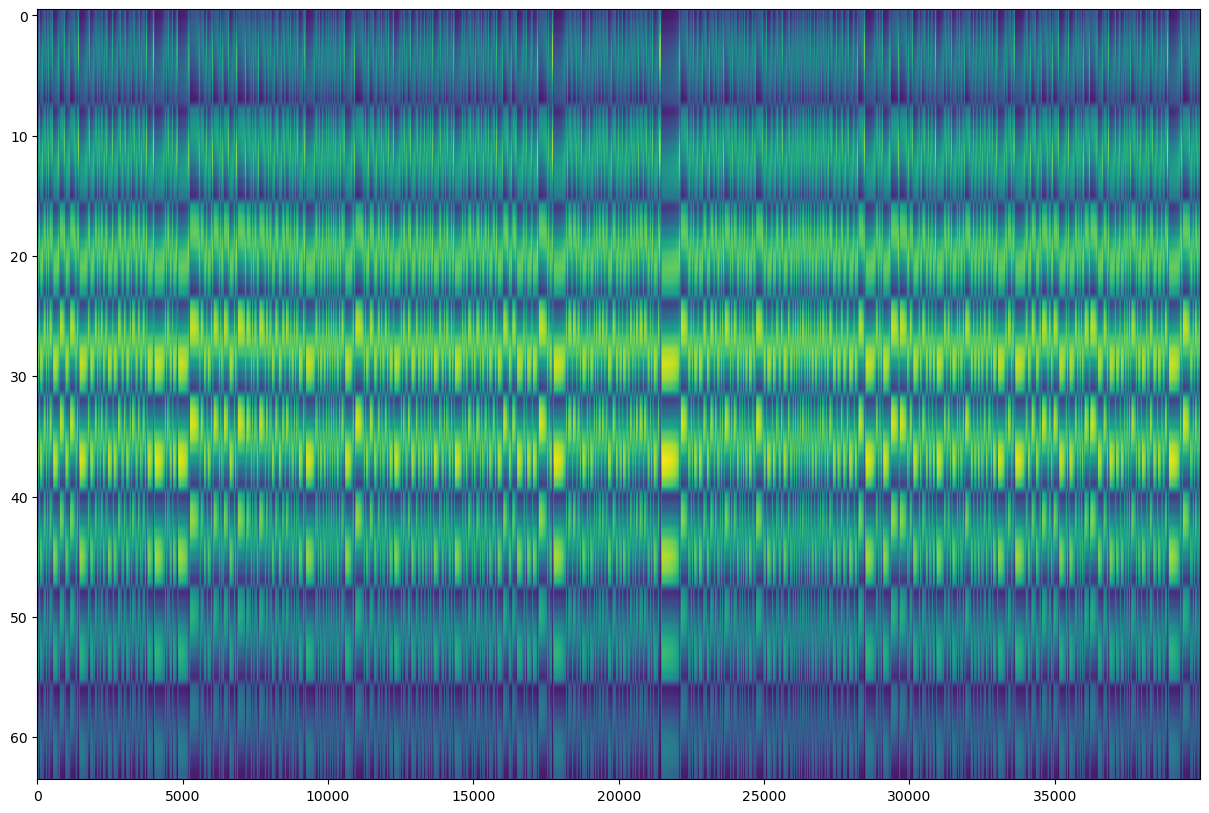

In [14]:
plt.figure(figsize=(15,10))
plt.imshow(observables.T,aspect="auto")

In [48]:
trainer = IMD.IMD_nD(observables.shape[1], embed_dim=3, n_components=10,subtract_corr=True, device="cuda")

In [49]:
trainer.fit(observables, sample_len=400, library_len=1200, 
            exclusion_rad=20, nbrs_num=30, tp=20, 
            epochs=2000, num_batches=32,optimizer="Adagrad", learning_rate=0.002,tp_policy="fixed")


Epoch 1/2000, Loss: 1.2057
Epoch 2/2000, Loss: 1.1183
Epoch 3/2000, Loss: 1.0761
Epoch 4/2000, Loss: 1.0446
Epoch 5/2000, Loss: 1.0158
Epoch 6/2000, Loss: 0.9971
Epoch 7/2000, Loss: 0.9779
Epoch 8/2000, Loss: 0.9615
Epoch 9/2000, Loss: 0.9495
Epoch 10/2000, Loss: 0.9358
Epoch 11/2000, Loss: 0.9244
Epoch 12/2000, Loss: 0.9134
Epoch 13/2000, Loss: 0.9028
Epoch 14/2000, Loss: 0.8943
Epoch 15/2000, Loss: 0.8851
Epoch 16/2000, Loss: 0.8734
Epoch 17/2000, Loss: 0.8693
Epoch 18/2000, Loss: 0.8616
Epoch 19/2000, Loss: 0.8521
Epoch 20/2000, Loss: 0.8486
Epoch 21/2000, Loss: 0.8428
Epoch 22/2000, Loss: 0.8358
Epoch 23/2000, Loss: 0.8259
Epoch 24/2000, Loss: 0.8172
Epoch 25/2000, Loss: 0.8079
Epoch 26/2000, Loss: 0.7982
Epoch 27/2000, Loss: 0.7898
Epoch 28/2000, Loss: 0.7867
Epoch 29/2000, Loss: 0.7821
Epoch 30/2000, Loss: 0.7715
Epoch 31/2000, Loss: 0.7699
Epoch 32/2000, Loss: 0.7645
Epoch 33/2000, Loss: 0.7527
Epoch 34/2000, Loss: 0.7498
Epoch 35/2000, Loss: 0.7516
Epoch 36/2000, Loss: 0.7454
E

KeyboardInterrupt: 

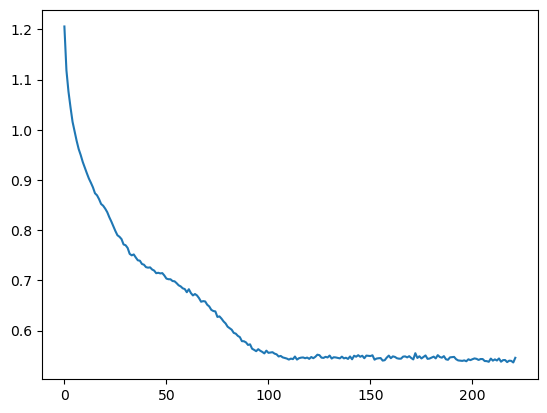

In [50]:
plt.plot(trainer.get_loss_history()[:])


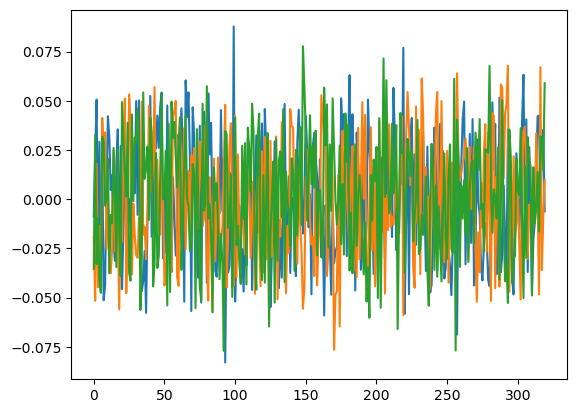

In [51]:
plt.plot(trainer.model.get_weights()[:,0])

In [54]:

unmixed = trainer.predict(observables)

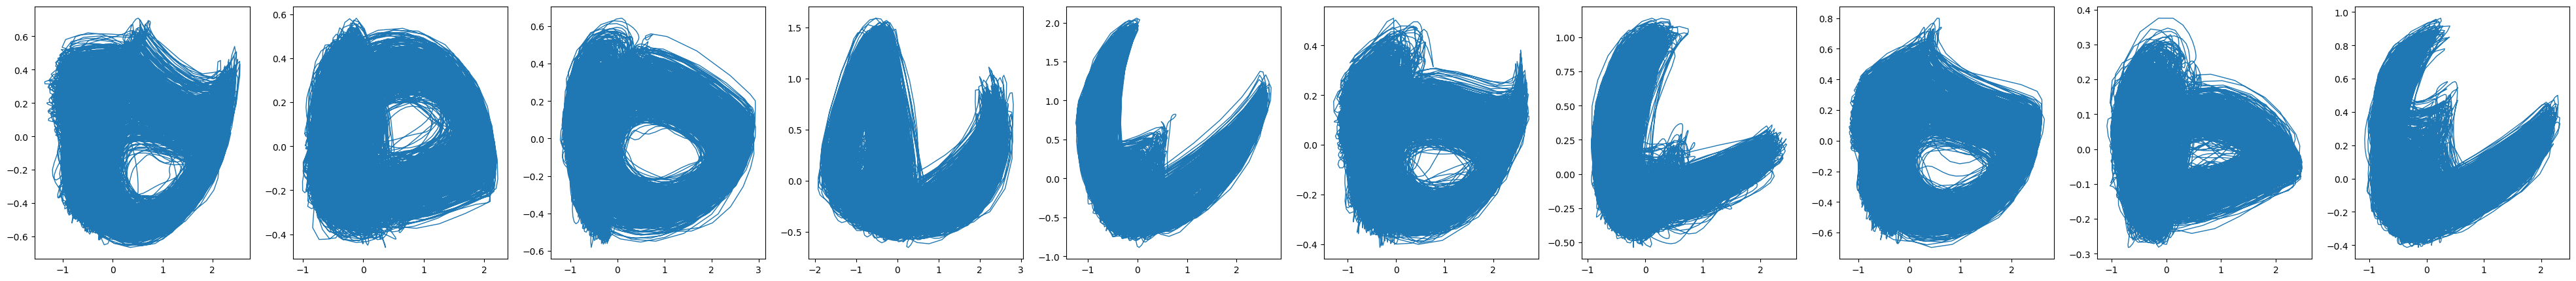

In [55]:
plt.figure(figsize=(5*unmixed.shape[1],5))
for i in range(unmixed.shape[1]):
    plt.subplot(1,unmixed.shape[1],i+1)
    x_pca = PCA(2).fit_transform(unmixed[:,i,:])
    plt.plot(x_pca[:,0],x_pca[:,1],linewidth=1)

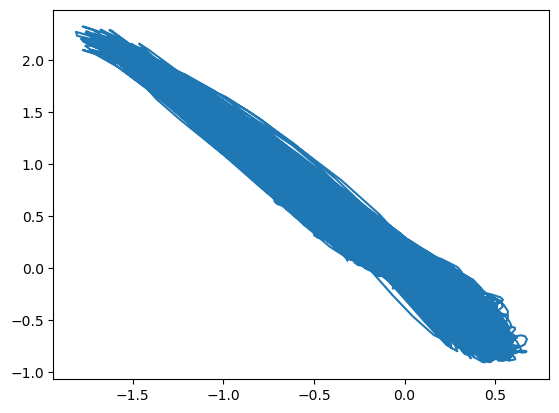

In [56]:
plt.plot(unmixed[:,4,1],unmixed[:,4,2])

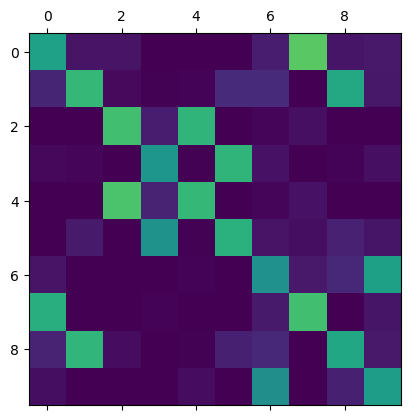

In [57]:
plt.matshow(CCM.PairwiseCCM().compute(np.transpose(unmixed,axes=(1,0,2)),np.transpose(unmixed,axes=(1,0,2)),1500,400,60,30,30).mean(axis=0),vmin=0,vmax=1)

In [58]:
import plotly.express as px
x_pca = PCA(3).fit_transform(unmixed[:,0,:])
fig = px.line_3d(x=x_pca[:,0], y=x_pca[:,1],z=x_pca[:,2],height=700)

fig.show()

In [59]:
havok = HAVOK(svd_rank=0,delays=1,lag=1,num_chaos=5,)

havok.fit(observables.T,np.arange(observables.shape[0]))

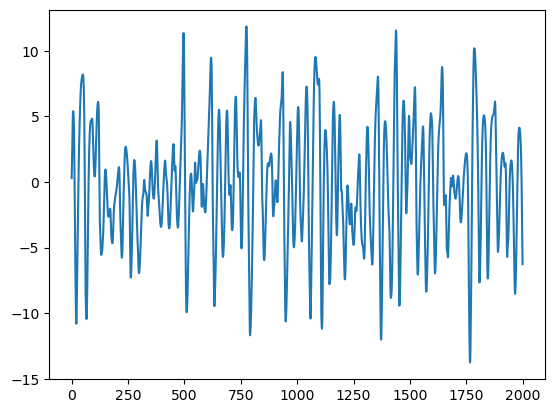

In [60]:
plt.plot((observables @ havok.modes[:,1].real)[:2000])

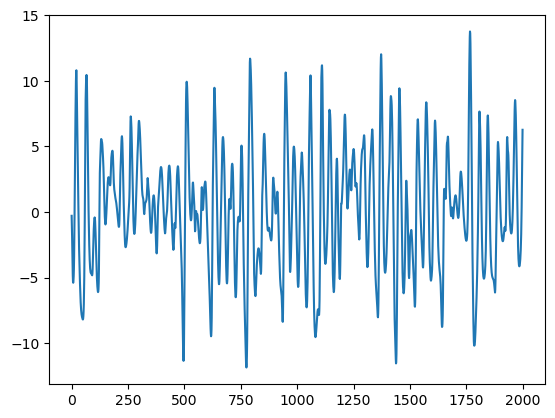

In [61]:
plt.plot(PCA(3).fit_transform(observables)[:2000,1])

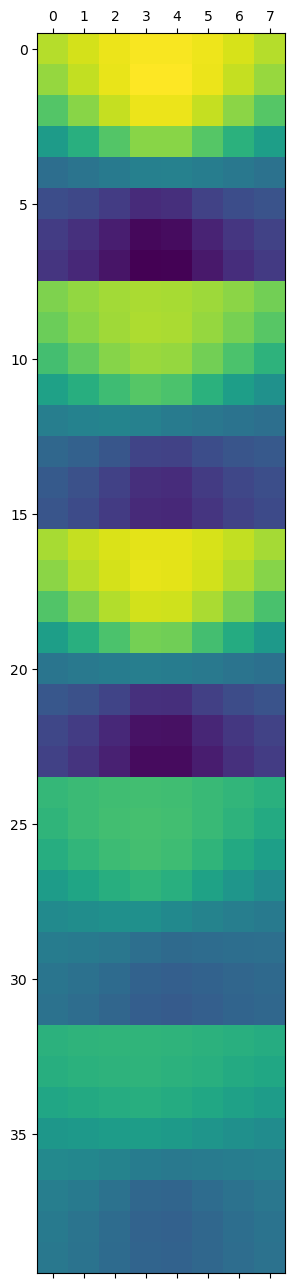

In [62]:
plt.matshow(havok.modes[:,0].reshape(40,8))

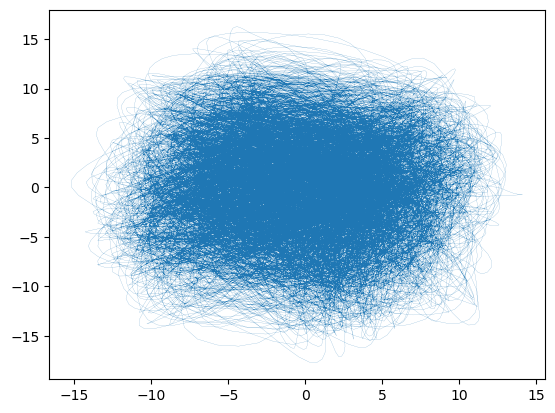

In [63]:
plt.plot((observables @ havok.modes)[:,2],(observables @ havok.modes)[:,1],linewidth=0.1)

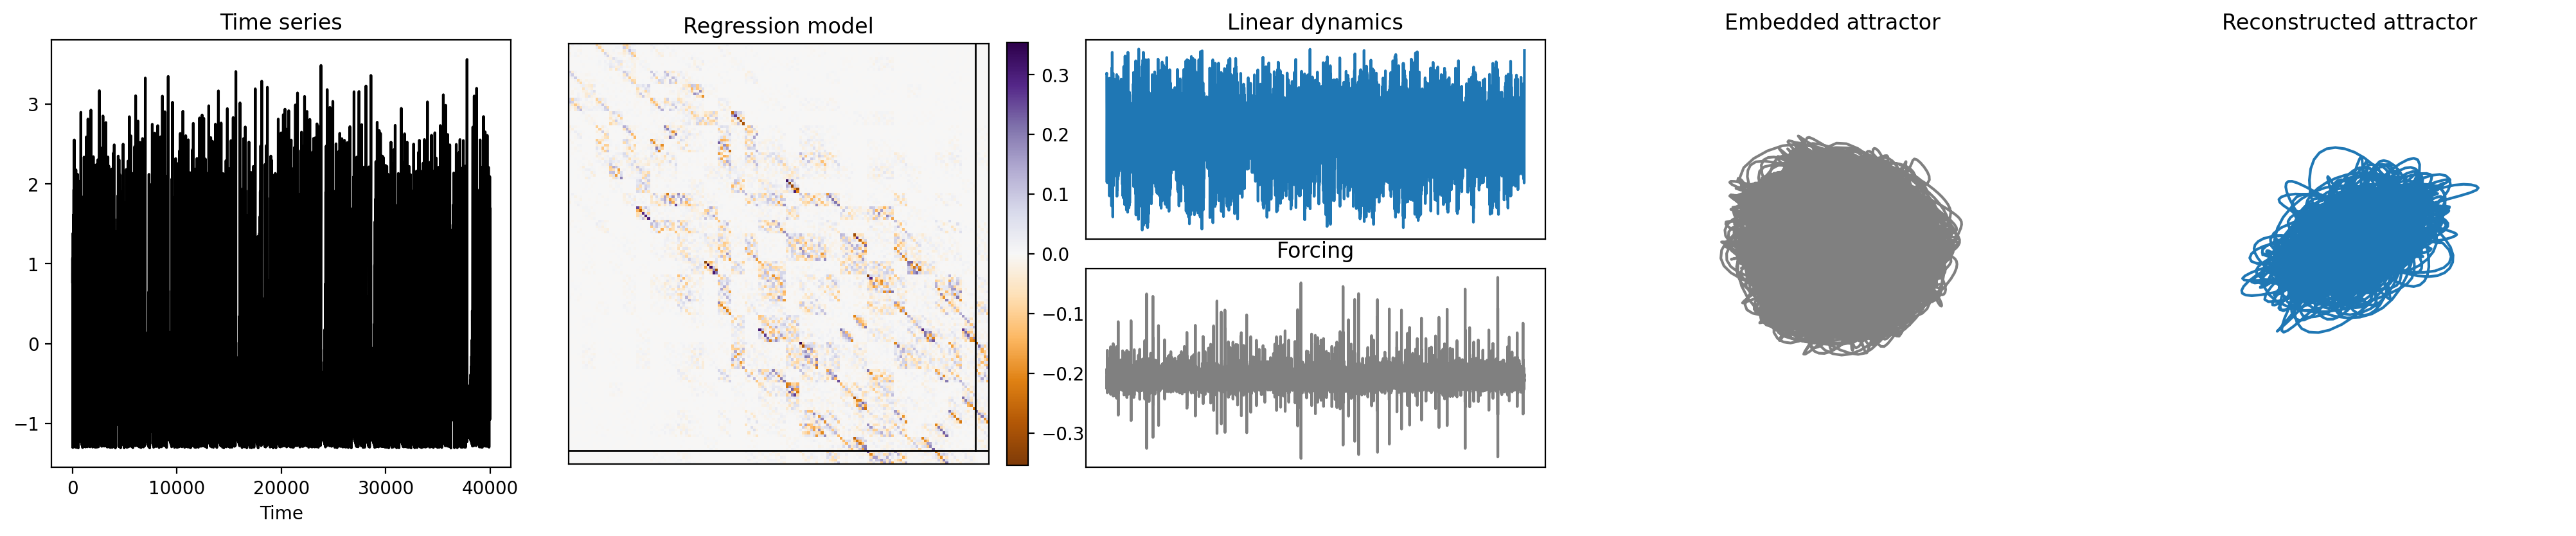

In [64]:
havok.plot_summary()